In [1]:
import matplotlib.pyplot as plt
import os
import numpy as np
from neuron import h, load_mechanisms
from netpyne import specs, sim, cell, support

In [2]:
h.load_file("stdrun.hoc")

cwd = os.getcwd()
mod_dir = os.path.join(cwd, 'mod')
load_mechanisms(mod_dir)

True

In [3]:
cfg = specs.SimConfig()					                    # object of class SimConfig to store simulation configuration
cfg.duration = 1000 						                # Duration of the simulation, in ms
cfg.dt = 0.1								                # Internal integration timestep to use
cfg.verbose = True							                # Show detailed messages
# cfg.recordTraces = {'V_soma':{'sec':'soma_0','loc':0.5,'var':'v'}}  # Dict with traces to record
cfg.recordStep = 0.1
# cfg.recordStim = True
cfg.filename = os.path.join(cwd, 'output', 'tinnitus_small-net') 	# Set file output name
cfg.savePickle = True
# cfg.analysis['plotTraces'] = {'include': ['all'], 'saveFig': True}  # Plot recorded traces for this list of cells
cfg.hParams['celsius'] = 34.0 
cfg.hParams['v_init'] = -60

In [4]:
netParams = specs.NetParams()

In [5]:
netParams.cellParams['IntFire1'] = {
    'cellModel': 'IntFire1',
    'tau': 5,
    'refrac': 3
}

In [6]:
pop_labels = ['AC', 'Int', 'IC', 'Fusi1', 'Fusi2']

netParams.popParams['input'] = {'cellModel': 'VecStim',
                                'numCells': 1,
                                'spikePattern': {'type': 'poisson',
                                                 'start': 0,
                                                 'stop': 1000,
                                                 'frequency': 200}}


netParams.popParams[f'{pop_labels[0]}_pop'] = {'cellType': 'IntFire1',
                                              'numCells': 1}
netParams.popParams[f'{pop_labels[3]}_pop'] = {'cellType': 'IntFire1',
                                              'numCells': 1}


In [7]:
netParams.synMechParams['exc'] = {'mod': 'ExpSyn', 'tau': 3, 'e': -10}
netParams.synMechParams['inh'] = {'mod': 'ExpSyn', 'tau': 10, 'e': -70}

In [8]:
netParams.connParams[f'input->AC'] = {
    'preConds': {'pop': 'input'},
    'postConds': {'pop': 'AC_pop'},
    'synsPerConn': 1,
    'synMech': 'exc',
    'weight': 1
}

netParams.connParams[f'AC->Fusi1'] = {
    'preConds': {'pop': 'AC_pop'},
    'postConds': {'pop': 'Fusi1_pop'},
    'probability': 1,
    'synsPerConn': 1,
    'synMech': 'exc',
    'weight': 1
}

In [9]:
(pops, cells, conns, stims, simData) = sim.createSimulateAnalyze(netParams=netParams, simConfig=cfg, output=True)


Start time:  2024-09-15 15:55:39.777071

Creating network of 3 cell populations on 1 hosts...
Distributed population of 1 cells on 1 hosts: {0: [0]}, next: 0
    Error while setting 'spikePattern' param to VecStim[0]
Cell 0/0 (gid=0) of pop input, on node 0, 
Instantiated 1 cells of population input
Distributed population of 1 cells on 1 hosts: {0: [0]}, next: 0
Cell 0/0 (gid=1) of pop AC_pop, on node 0, 
Instantiated 1 cells of population AC_pop
Distributed population of 1 cells on 1 hosts: {0: [0]}, next: 0
Cell 0/0 (gid=2) of pop Fusi1_pop, on node 0, 
Instantiated 1 cells of population Fusi1_pop
  Number of cells on node 0: 3 
  Done; cell creation time = 0.00 s.
Making connections...
Generating set of all-to-all connections (rule: input->AC) ...
  Created connection preGid=0
Generating set of probabilistic connections (rule: AC->Fusi1) ...
  Created connection preGid=1
  Number of connections on node 0: 2 
  Done; cell connection time = 0.00 s.
  Number of stims on node 0: 0 
  D

input: 215 spikes
AC_pop: 67 spikes
Fusi1_pop: 33 spikes


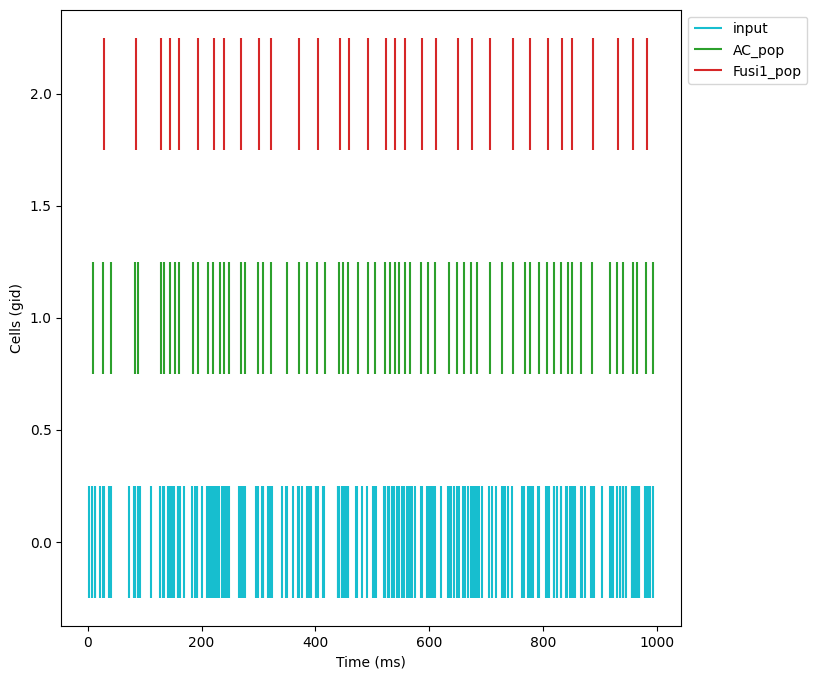

In [10]:
times = np.array(simData['spkt'])
spikes = np.array(simData['spkid'])

colors = {'AC_pop': 'tab:green', 'Int_pop': 'tab:blue', 'IC_pop': 'tab:purple', 'Fusi1_pop': 'tab:red', 'Fusi2_pop': 'tab:red', 'input': 'tab:cyan'}

fig, axs = plt.subplots(1, 1, figsize=(8,8))

input_spike_t = []

for pop_label, pop in pops.items():
    for gid in pop.cellGids:
        cell = cells[gid]
        spike_times = times[np.where(spikes == gid)]
        if gid == 5:
            input_spike_t = spike_times

        # loc = -1 if gid == 5 else gid
        axs.vlines(spike_times, gid-0.25, gid+0.25, color=colors[pop_label], label=pop_label)

        print(f'{pop_label}: {spike_times.shape[0]} spikes')


axs.legend(loc='upper left', bbox_to_anchor=(1, 1))
# axs.set_yticks([-1, 0, 1, 2, 3, 4])
# # axs.set_yticklabels(['5','0','1','2','3', '4'])
axs.set_ylabel('Cells (gid)')
axs.set_xlabel('Time (ms)');